In [2]:
import os
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, LearningRateScheduler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import time
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, TimeDistributed, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, X_path, y_path, indices, batch_size):
        assert os.path.exists(X_path), f"X_path {X_path} does not exist."
        assert os.path.exists(y_path), f"y_path {y_path} does not exist."
        
        self.X = np.memmap(X_path, dtype='float32', mode='r', shape=(1612, 15, 224, 224, 3))
        self.y = np.memmap(y_path, dtype='int32', mode='r', shape=(1612,))
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_indices]
        X_batch = preprocess_input(X_batch)
        y_batch = np.eye(2)[self.y[batch_indices]]
        return X_batch, y_batch
    
class StepTimerCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\n--- Starting Epoch {epoch + 1} ---")
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        print(f"--- Epoch {epoch + 1} completed in {epoch_time:.2f} seconds ---\n")

    def on_train_batch_begin(self, batch, logs=None):
        self.step_start_time = time.time()
        print(f"Step {batch + 1}/{self.params['steps']} - ", end="")

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.step_start_time
        print(f"Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}, Time: {step_time:.2f} seconds")
        
class BatchEarlyStopping(Callback):
    def __init__(self, monitor='loss', threshold=0.1, patience=5):
        """
        Early stopping within the same epoch based on a monitored metric.
        Args:
            monitor: Metric to monitor ('loss', 'accuracy', etc.).
            threshold: Threshold value for stopping (e.g., loss < 0.1).
            patience: Number of batches to wait for improvement before stopping.
        """
        super().__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_train_batch_end(self, batch, logs=None):
        current_value = logs.get(self.monitor)
        if current_value is not None:
            if current_value < self.threshold:
                self.wait += 1
                if self.wait >= self.patience:
                    print(f"\nEarly stopping triggered at batch {batch + 1}: {self.monitor} = {current_value:.4f}")
                    self.model.stop_training = True
            else:
                self.wait = 0 

batch_early_stopping_callback = BatchEarlyStopping(
    monitor='loss',     
    threshold=0.1,       
    patience=2          
)

model_path = r'E:\PosePerfect\Model\mobilenetV3_checkpoints\model_epoch_10_val_loss_0.66.keras'
cnn_lstm_model = load_model(model_path)

cnn_lstm_model.get_layer('time_distributed').layer.trainable = True

for layer in cnn_lstm_model.get_layer('time_distributed').layer.layers[:-20]:
    layer.trainable = False

cnn_lstm_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
cnn_lstm_model.summary()

indices = np.arange(1612)
train_indices, val_indices = train_test_split(indices, test_size=0.3, random_state=42)

train_gen = DataGenerator(r'E:\PosePerfect\Dataset Creation\X_final_1612.dat', r'E:\PosePerfect\Dataset Creation\y_final_1612.dat', train_indices, batch_size=12)
val_gen = DataGenerator(r'E:\PosePerfect\Dataset Creation\X_final_1612.dat', r'E:\PosePerfect\Dataset Creation\y_final_1612.dat', val_indices, batch_size=12)

checkpoint_dir = './Finetune_mobilenetV3_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  
    save_best_only=False,
    save_weights_only=False,  
    verbose=1
)

def scheduler(epoch, lr):
    if epoch < 2: 
        return lr
    return lr * 0.9 

lr_callback = LearningRateScheduler(scheduler)

step_timer_callback = StepTimerCallback()

cnn_lstm_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    steps_per_epoch=len(train_gen),
    validation_steps=len(val_gen),
    callbacks=[checkpoint_callback, lr_callback, step_timer_callback, batch_early_stopping_callback],
    verbose=1  
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 7, 7, 576)  │       939,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 15, 28224)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │    14,516,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,595,826 (59.49 MB)

 Trainable params: 15,007,442 (57.25 MB)

 Non-trainable params: 588,384 (2.24 MB)


--- Starting Epoch 1 ---
Epoch 1/10
Step 1/94 - Loss: 0.8288, Accuracy: 0.3333, Time: 81.92 seconds
 1/94 ━━━━━━━━━━━━━━━━━━━━ 2:21:17 91s/step - accuracy: 0.3333 - loss: 0.8288Step 2/94 - Loss: 0.7381, Accuracy: 0.4583, Time: 1.98 seconds
 2/94 ━━━━━━━━━━━━━━━━━━━━ 3:12 2s/step - accuracy: 0.3958 - loss: 0.7834    Step 3/94 - Loss: 0.7172, Accuracy: 0.5000, Time: 1.99 seconds
 3/94 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.4306 - loss: 0.7614Step 4/94 - Loss: 0.7140, Accuracy: 0.5208, Time: 1.87 seconds
 4/94 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.4531 - loss: 0.7495Step 5/94 - Loss: 0.6971, Accuracy: 0.5500, Time: 1.85 seconds
 5/94 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.4725 - loss: 0.7390Step 6/94 - Loss: 0.7095, Accuracy: 0.5278, Time: 1.80 seconds
 6/94 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.4817 - loss: 0.7341Step 7/94 - Loss: 0.7203, Accuracy: 0.4881, Time: 1.82 seconds
 7/94 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.4826 - loss: 0.7321St

In [6]:
model_path = r'E:\PosePerfect\Model\Finetune_mobilenetV3_checkpoints\model_epoch_07_val_loss_0.27.keras'
cnn_lstm_model = load_model(model_path)

val_loss, val_accuracy = cnn_lstm_model.evaluate(val_gen, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

E:\PosePerfect\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9167 - loss: 0.2707
Validation Loss: 0.2670
Validation Accuracy: 0.9125


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
y_true = np.argmax(y_true, axis=1)  

y_pred = cnn_lstm_model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

40/40 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.85      0.91       242
     Class 1       0.87      0.97      0.92       238

    accuracy                           0.91       480
   macro avg       0.92      0.91      0.91       480
weighted avg       0.92      0.91      0.91       480

Confusion Matrix:
[[206  36]
 [  6 232]]


In [102]:
path = 'E:\PosePerfect\Model\Process Example\X_biceps_5.dat'
output_x_path = path

X_shape = (2, 15, 224, 224, 3)

X_loaded = np.memmap(output_x_path, dtype='float32', mode='r', shape=X_shape)

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\ACER\AppData\Local\Temp\ipykernel_8488\2722879653.py:1: SyntaxWarning: invalid escape sequence '\P'
  path = 'E:\PosePerfect\Model\Process Example\X_biceps_5.dat'


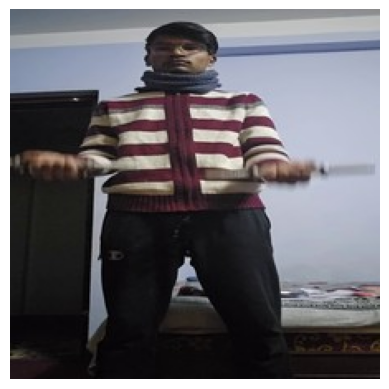

In [103]:
import matplotlib.pyplot as plt

x = 0
y = 14
plt.imshow(X_loaded[x][y] )
plt.axis('off')
plt.show()

In [104]:
example_input = np.memmap(
    path,
    dtype='float32',
    mode='r',
    shape=(1, 15, 224, 224, 3)
)

example_input_writable = np.array(example_input) 

example_input_preprocessed = preprocess_input(example_input_writable)
print("Input preprocessed successfully!")

print(f"Input Shape: {example_input_preprocessed.shape}")
print(f"Input Summary: Min={example_input_preprocessed.min()}, Max={example_input_preprocessed.max()}, Mean={example_input_preprocessed.mean()}")

predictions = cnn_lstm_model.predict(example_input_preprocessed)
predicted_class = np.argmax(predictions, axis=1)

print("Raw Predictions:", predictions)
print("Predicted Class Probabilities:", predictions[0]) 
print(f"Predicted Class: {predicted_class}")

Input preprocessed successfully!
Input Shape: (1, 15, 224, 224, 3)
Input Summary: Min=0.0, Max=1.0, Mean=0.37605294585227966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Raw Predictions: [[0.55451256 0.4454874 ]]
Predicted Class Probabilities: [0.55451256 0.4454874 ]
Predicted Class: [0]


In [106]:
new_save_folder = r'E:\PosePerfect\Model\Final_Models'
os.makedirs(new_save_folder, exist_ok=True)

new_model_path = os.path.join(new_save_folder, 'modelv3.keras')
cnn_lstm_model.save(new_model_path)

print(f"Model saved successfully to {new_model_path}!")

Model saved successfully to E:\PosePerfect\Model\Final_Models\modelv3.keras!


In [109]:
import natsort

checkpoint_dir = './mobilenetV3_checkpoints'
checkpoint_files = natsort.natsorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.keras')])

print(checkpoint_files)

['./mobilenetV3_checkpoints\\model_epoch_01_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_02_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_03_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_04_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_05_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_06_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_07_val_loss_0.69.keras', './mobilenetV3_checkpoints\\model_epoch_08_val_loss_0.68.keras', './mobilenetV3_checkpoints\\model_epoch_09_val_loss_0.67.keras', './mobilenetV3_checkpoints\\model_epoch_10_val_loss_0.66.keras']


In [110]:
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for checkpoint_path in checkpoint_files:
    print(f"Evaluating {checkpoint_path}...")
    model = load_model(checkpoint_path)

    train_metrics = model.evaluate(train_gen, verbose=0)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])

    val_metrics = model.evaluate(val_gen, verbose=0)
    val_loss.append(val_metrics[0])
    val_acc.append(val_metrics[1])


Evaluating ./mobilenetV3_checkpoints\model_epoch_01_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_02_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_03_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_04_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_05_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_06_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_07_val_loss_0.69.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_08_val_loss_0.68.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_09_val_loss_0.67.keras...
Evaluating ./mobilenetV3_checkpoints\model_epoch_10_val_loss_0.66.keras...


In [113]:
save_train_loss, save_val_loss, save_train_acc, save_val_acc = train_loss, val_loss, train_acc, val_acc

In [114]:
checkpoint_dir = './Finetune_mobilenetV3_checkpoints'
checkpoint_files = natsort.natsorted([os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.keras')])

print(checkpoint_files)

['./Finetune_mobilenetV3_checkpoints\\model_epoch_01_val_loss_0.70.keras', './Finetune_mobilenetV3_checkpoints\\model_epoch_02_val_loss_0.67.keras', './Finetune_mobilenetV3_checkpoints\\model_epoch_03_val_loss_0.54.keras', './Finetune_mobilenetV3_checkpoints\\model_epoch_04_val_loss_0.43.keras', './Finetune_mobilenetV3_checkpoints\\model_epoch_05_val_loss_0.32.keras', './Finetune_mobilenetV3_checkpoints\\model_epoch_06_val_loss_0.27.keras', './Finetune_mobilenetV3_checkpoints\\model_epoch_07_val_loss_0.27.keras']


In [115]:
for checkpoint_path in checkpoint_files:
    print(f"Evaluating {checkpoint_path}...")
    model = load_model(checkpoint_path)

    train_metrics = model.evaluate(train_gen, verbose=0)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])

    val_metrics = model.evaluate(val_gen, verbose=0)
    val_loss.append(val_metrics[0])
    val_acc.append(val_metrics[1])

Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_01_val_loss_0.70.keras...
Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_02_val_loss_0.67.keras...
Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_03_val_loss_0.54.keras...
Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_04_val_loss_0.43.keras...
Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_05_val_loss_0.32.keras...
Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_06_val_loss_0.27.keras...
Evaluating ./Finetune_mobilenetV3_checkpoints\model_epoch_07_val_loss_0.27.keras...


In [116]:
print(train_loss)

[0.6928314566612244, 0.6914809942245483, 0.6911193132400513, 0.6908026337623596, 0.6874557137489319, 0.6907005310058594, 0.6876027584075928, 0.6829379200935364, 0.6700130701065063, 0.6749900579452515, 0.6935732364654541, 0.6742455363273621, 0.5350159406661987, 0.4152326285839081, 0.3058505356311798, 0.2537637948989868, 0.25137859582901]


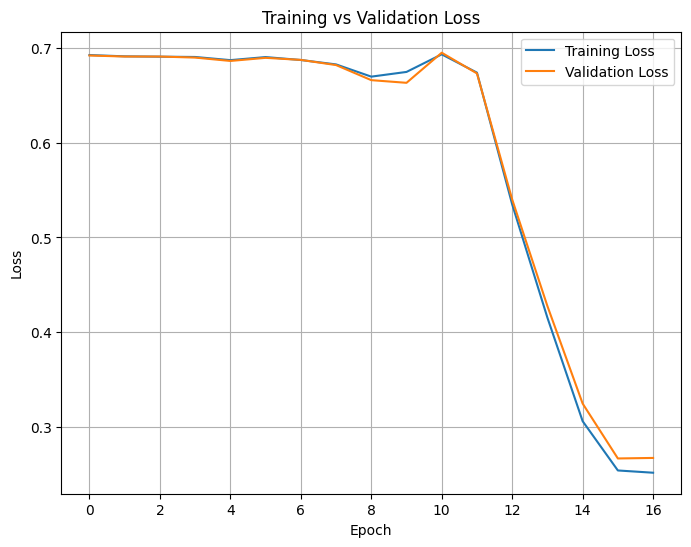

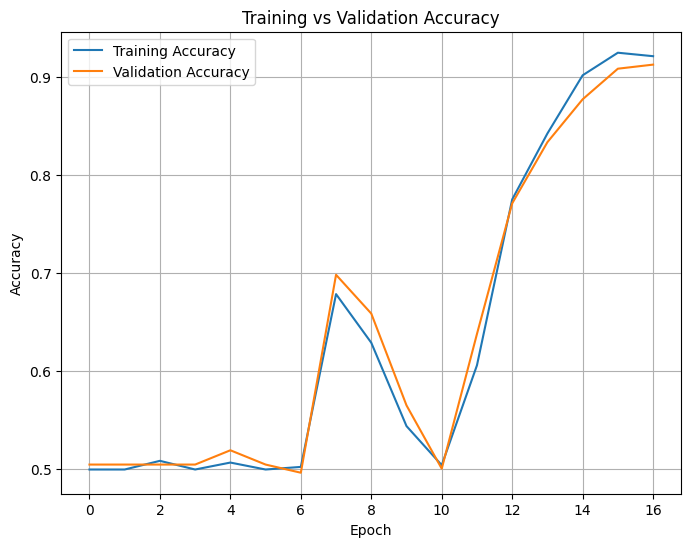

In [118]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()
